In [1]:
import os
os.environ['AWS_CONFIG_FILE'] = '../.aws/config'

import json
import random
import time
from pathlib import Path
from typing import Optional
from functools import partial
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp

import boto3
import s3fs
import polars as pl
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

## Utils

In [2]:
def get_image_dimensions(image_path: str, image_folder: str, s3_fs: Optional[s3fs.S3FileSystem]) -> Optional[dict]:
    if image_path is None:
        return None

    abs_image_path = f"{image_folder}/{image_path}"
    img = None
    try:
        with s3_fs.open(abs_image_path, "rb") as f:
            img = Image.open(f)
    except Exception as e:
        print(f"Error getting image dimensions for {image_path}: {e}")
        return None

    if img is not None:
        width, height = img.width, img.height
        ar = round(width / height, 2)
        return {"width": width, "height": height, "ar": ar}
    else:
        return None
    
def get_image_path(item_id: str, image_extension: str = ".jpg") -> str:
    return f"{item_id[:5]}/{item_id}{image_extension}"

## Set credentials

In [3]:
def s3_auth():
    session = boto3.session.Session(profile_name='default')
    credentials = session.get_credentials().get_frozen_credentials()
    
    s3_fs = s3fs.S3FileSystem(
        key=credentials.access_key,
        secret=credentials.secret_key,
        endpoint_url='https://s3.gra.io.cloud.ovh.net',
    )
    return s3_fs, credentials

In [4]:
aws_region = 'gra'
aws_endpoint_url = 'https://s3.gra.io.cloud.ovh.net'
bucket_name = 'fc-gra-alejandria'
ds_path = f'{bucket_name}/ds/public/PD12M'

# Initialize boto3 S3 client
s3_fs, credentials = s3_auth()
s3_storage_options = {
    "aws_access_key_id": credentials.access_key,
    "aws_secret_access_key": credentials.secret_key,
    "endpoint_url": aws_endpoint_url,
    "aws_region": aws_region,
}

## Read and format data

In [5]:
ds_folder = 's3://fc-gra-alejandria/ds/public/PD12M'
parquet_files = list(s3_fs.glob(ds_folder + "/*.parquet"))
parquet_files = [f"s3://{file}" for file in parquet_files]
print(f"Found {len(parquet_files)} parquet files in {ds_folder}")

df = pl.read_parquet(parquet_files[0], storage_options=s3_storage_options)
df = df.to_pandas()
print(f"Number of rows: {len(df)}")

Found 1241 parquet files in s3://fc-gra-alejandria/ds/public/PD12M
Number of rows: 9996


In [6]:
# Rename columns
df = df.rename(columns={
    "key": "item_id",
    "width": "image_width",
    "height": "image_height",
})
df["image_path"] = df.apply(lambda row: get_image_path(row["item_id"]), axis=1)

## Benchmarking

In [7]:
image_paths = df["image_path"].tolist()[:500]
num_workers_list = [16, 32, 64, 128]

### Threading

In [8]:
inference_times = []
for num_workers in tqdm(num_workers_list):
    tic = time.time()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(
            get_image_dimensions, image_path, ds_folder, s3_fs
        ) for image_path in image_paths]
        results = list(as_completed(futures))
    toc = time.time()
    elapsed_time = toc - tic
    avg_time = elapsed_time / len(image_paths)
    inference_times.append(avg_time)

100%|██████████| 4/4 [00:49<00:00, 12.34s/it]


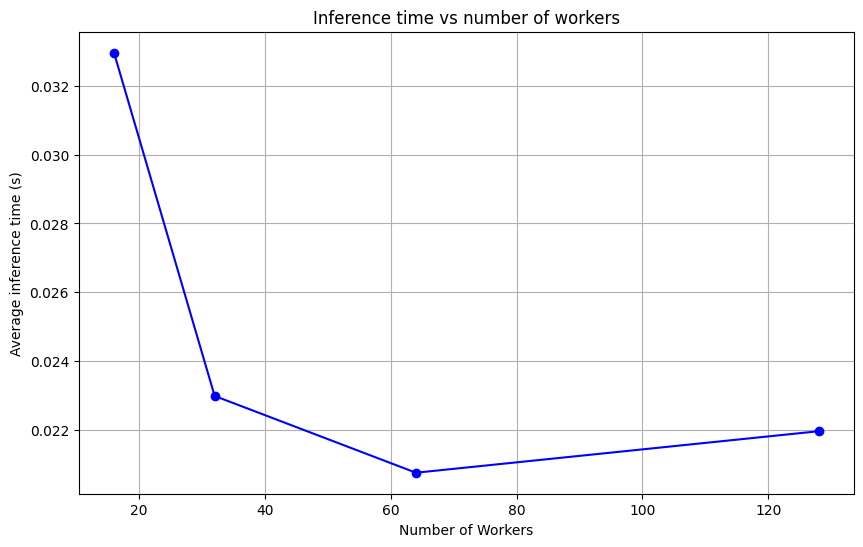

In [9]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(num_workers_list, inference_times, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Workers')
plt.ylabel('Average inference time (s)')
plt.title('Inference time vs number of workers')
plt.grid(True)
plt.show()

### Multiprocessing

In [ ]:
inference_times_mp = []
dest_folder = "output"
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)

num_workers = [2, 4, 8]
for num_workers in tqdm(num_workers_list):
    tic = time.time()
    with mp.Pool(processes=num_workers) as pool:
        results = pool.map(
            partial(process_parquet, ds_folder=ds_folder, dest_folder=dest_folder, max_items=50),
            parquet_files[:10]
        )
    toc = time.time()
    inference_times_mp.append(toc - tic)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_workers_list, inference_times_mp, marker='o', linestyle='-', label='Multiprocessing', color='r')
plt.xlabel('Number of Workers')
plt.ylabel('Inference Time (s)')
plt.title('Threading vs Multiprocessing Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()